In [3]:
import numpy as np
import pandas as pd

def get_column_names(df, col_nums):
    col_names = []
    for col_num in col_nums:
        if col_num < len(df.columns):
            col_names.append(df.columns[col_num])
        else:
            col_names.append("Column number out of range")
    return col_names

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred):
    return -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))

def stochastic_gradient_descent(X, y, learning_rate=0.001, l1_reg=0, l2_reg=0):
    # Initialize weights
    weights = np.zeros(X.shape[1])
    bias = 0

    n = len(y)

    for i in range(n):
        # Randomly select an index for SGD
        rand_index = np.random.randint(0, n)
        xi = X[rand_index, :]
        yi = y[rand_index]

        # Prediction
        linear_output = np.dot(xi, weights) + bias
        y_pred = sigmoid(linear_output)

        # Compute gradients
        gradient_w = (y_pred - yi) * xi
        gradient_b = (y_pred - yi)

        # Update weights and bias with L1 and L2 regularization options
        weights -= learning_rate * (gradient_w + l2_reg * weights + l1_reg * np.sign(weights))
        bias -= learning_rate * gradient_b

    return weights, bias

def predict(X, weights, bias):
    linear_output = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_output)
    return np.round(y_pred)  # Return 0 or 1

def forward_stepwise_selection(X_train, y_train, X_val, y_val, learning_rate=0.001, l2_reg=0):
    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(range(n_features))
    best_accuracy = 0
    best_weights = None
    best_bias = None

    while remaining_features:
        best_feature = None
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            X_train_subset = X_train[:, features_to_try]
            X_val_subset = X_val[:, features_to_try]

            weights, bias = stochastic_gradient_descent(X_train_subset, y_train, learning_rate=learning_rate, l1_reg=0, l2_reg=l2_reg)
            y_val_pred = predict(X_val_subset, weights, bias)
            val_accuracy = np.mean(y_val_pred == y_val)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_feature = feature
                best_weights = weights
                best_bias = bias

        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    return selected_features, best_weights, best_bias

/var/folders/38/vhxn_3_d46gc6yjxx7zjfcvm0000gn/T/ipykernel_94885/3468247467.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['famhist'] = df['famhist'].replace({'Present': 1, 'Absent': 0})


Unregularized Model Accuracy: 0.7021
L2 Regularized Model Accuracy: 0.7872
Tuned Model Accuracy: 0.7174
best learning rate: 0.01
best l2: 4.641588833612773e-06
Stepwise Model Accuracy: Test=0.7660
Selected Features=['sbp', 'ldl']
L1 Regularized Model Accuracy: Test=0.6739
Best L1: Test=0.008751958772041732
Selected Features=['tobacco', 'ldl', 'famhist', 'alcohol', 'age']


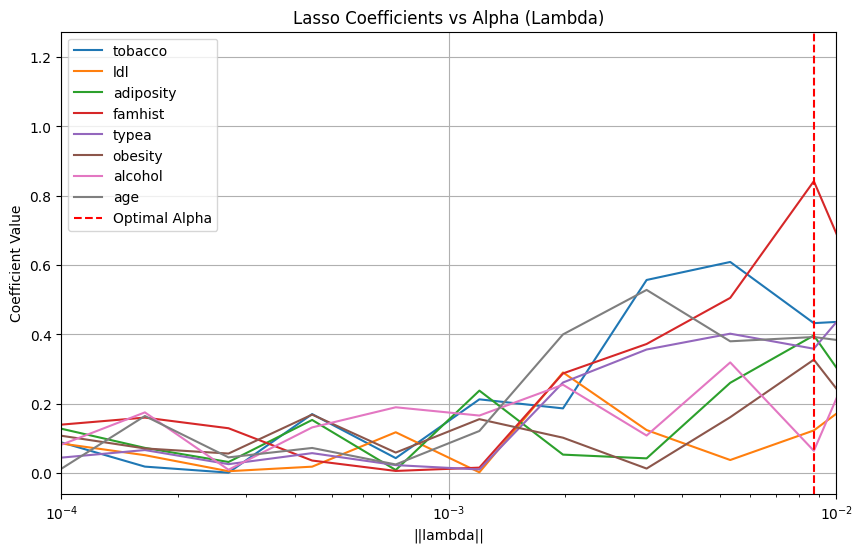


Accuracy Scores: 
   Unregularized  L2 Regularized  Tuned Model  Stepwise Model  L1 Model
0       0.702128        0.787234     0.717391        0.765957  0.673913


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from champfunc import stochastic_gradient_descent, predict, forward_stepwise_selection, get_column_names

# Loading the data
url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data'
df = pd.read_csv(url, index_col=0)

# Make it all numerical
df['famhist'] = df['famhist'].replace({'Present': 1, 'Absent': 0})

# randomly mix it up before splitting
df = df.sample(frac=1, replace=False, random_state=42)

# saving solumn names for graphs
feature_names = df.columns.tolist()

#sns.pairplot(df, height=2)
#plt.show()

np.random.seed(33)

X = df.drop('chd', axis=1).values
y = df['chd'].values

# Standarize the features before SGD
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Training/testing/validation split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

#Unregularized
weights, bias = stochastic_gradient_descent(X_train, y_train, learning_rate=0.0001)
y_test_pred = predict(X_test, weights, bias)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Unregularized Model Accuracy: {test_accuracy:.4f}")

# L2 regularization
weights_l2, bias_l2 = stochastic_gradient_descent(X_train, y_train, l2_reg=0.1)
y_test_pred_l2 = predict(X_test, weights_l2, bias_l2)
test_accuracy_l2 = np.mean(y_test_pred_l2 == y_test)
print(f"L2 Regularized Model Accuracy: {test_accuracy_l2:.4f}")

# Tuning optimal model
learning_rates = np.logspace(-10, -1, num=10)
l2_regs = np.logspace(-8, 0, num=10)
tuned_accuracy = 0
best_lr = 0
best_l2 = 0
for l2 in l2_regs:
    for lr in learning_rates:
        weights_tuned, bias_tuned = stochastic_gradient_descent(X_train, y_train, learning_rate=lr, l1_reg = 0, l2_reg=l2)
        y_val_pred_tuned = predict(X_val, weights_tuned, bias_tuned)
        val_accuracy_tuned = np.mean(y_val_pred_tuned == y_val)
        if val_accuracy_tuned > tuned_accuracy:
            tuned_accuracy = val_accuracy_tuned
            best_lr = lr
            best_l2 = l2

print(f"Tuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"best learning rate: {best_lr}")
print(f"best l2: {best_l2}")

# Forward Stepwise selection (using optimized model)
selected_features, best_weights, best_bias = forward_stepwise_selection(X_train, y_train, X_val, y_val, learning_rate=best_lr, l2_reg=best_l2)
X_test_subset = X_test[:, selected_features]
y_test_pred_stepwise = predict(X_test_subset, best_weights, best_bias)
test_accuracy_stepwise = np.mean(y_test_pred_stepwise == y_test)
print(f"Stepwise Model Accuracy: Test={test_accuracy_stepwise:.4f}")
print(f"Selected Features={get_column_names(df, selected_features)}")

# Tuning L1 regularization
l1_regs = np.logspace(-4, 0.1, num=20)
best_accuracy_l1 = 0
best_l1 = 0
best_l1_weights = []
l1_coeffs = []
for l1 in l1_regs:
    weights_tuned, bias_tuned = stochastic_gradient_descent(X_train, y_train, learning_rate= lr, l1_reg = l1, l2_reg=best_l2)
    l1_coeffs.append(weights_tuned)
    y_val_pred_tuned = predict(X_val, weights_tuned, bias_tuned)
    val_accuracy_tuned = np.mean(y_val_pred_tuned == y_val)
    if val_accuracy_tuned > best_accuracy_l1:
        best_accuracy_l1 = val_accuracy_tuned
        best_l1 = l1
        best_l1_weights = weights_tuned

print(f"L1 Regularized Model Accuracy: Test={best_accuracy_l1:.4f}")
print(f"Best L1: Test={best_l1}")
indices = np.where(np.abs(best_l1_weights) > 0.3)[0]
print(f"Selected Features={get_column_names(df, indices)}")

# Forward stepwise is selecting sbp and ldl, while L1 is selecting tobacco, ldl, famhist, alcohol, and age
# Both models select ldl

# graphing coefficients as Lambda is varied

l1_coeffs = np.flip(np.abs(np.array(l1_coeffs)))
plt.figure(figsize=(10, 6))
for i in range(l1_coeffs.shape[1]-1):
    plt.plot(l1_regs, l1_coeffs[:, i], label=get_column_names(df, np.arange(1, 10))[i]) 

plt.xscale('log')
plt.xlim(1e-4, 1e-2)
plt.axvline(x=best_l1, color='r', linestyle='--', label='Optimal Alpha')
plt.title('Lasso Coefficients vs Alpha (Lambda)')
plt.xlabel('||lambda||')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid()
plt.show()

# Outputting table of accuracy scores

scores = {
    'Unregularized': [test_accuracy],
    'L2 Regularized': [test_accuracy_l2],
    'Tuned Model': [tuned_accuracy],
    'Stepwise Model': [test_accuracy_stepwise],
    'L1 Model': [best_accuracy_l1],
}

champ = pd.DataFrame(scores)

print()
print("Accuracy Scores: ")
print(champ)